In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Load the datasets
df_dos_attack = pd.read_csv('c:/Users/diyah/Downloads/10) CAN-Intrusion Dataset/DoS_attack_dataset.csv')
df_impersonation_attack = pd.read_csv('c:/Users/diyah/Downloads/10) CAN-Intrusion Dataset/Impersonation_attack_dataset.csv')
df_fuzzy_attack = pd.read_csv('c:/Users/diyah/Downloads/10) CAN-Intrusion Dataset/Fuzzy_attack_dataset.csv')
df_attack_free = pd.read_csv('c:/Users/diyah/Downloads/10) CAN-Intrusion Dataset/Attack_free.csv')

# Add a label column to each dataset
df_attack_free['label'] = 0
df_dos_attack['label'] = 1
df_impersonation_attack['label'] = 1
df_fuzzy_attack['label'] = 1

In [4]:
# Concatenate all datasets into a single DataFrame
df = pd.concat([df_attack_free, df_dos_attack, df_impersonation_attack, df_fuzzy_attack], ignore_index=True)

def convert_to_int(x):
    if isinstance(x, str):
        try:
            return int(x, 16)
        except ValueError:
            return x
for col in df.filter(like='data'):
    df[col] = df[col].apply(convert_to_int)
df['can_id'] = df['can_id'].apply(convert_to_int)
# Fill NaN values with zeros (if any)
df.fillna(0, inplace=True)
df = df.drop(columns=['ignore'])
df = df.drop(columns=['dlc'])
X = df.drop(columns=['label'])
y = df['label']

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#feature extractor using a neural network in TensorFlow with Keras
feature_extractor = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(X_train.shape[1], activation='relu')  # Output layer with same dimensions as input
])

feature_extractor.compile(optimizer='adam', loss='mse')

In [25]:
# Train the feature extractor
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = feature_extractor.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2,callbacks=[early_stopping])

# Extract features
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)


Epoch 1/10
92269/92269 ━━━━━━━━━━━━━━━━━━━━ 262s 3ms/step - loss: 0.0302 - val_loss: 0.0338
Epoch 2/10
92269/92269 ━━━━━━━━━━━━━━━━━━━━ 312s 3ms/step - loss: 0.0247 - val_loss: 0.0355
Epoch 3/10
92269/92269 ━━━━━━━━━━━━━━━━━━━━ 203s 2ms/step - loss: 0.0245 - val_loss: 0.0367
Epoch 4/10
92269/92269 ━━━━━━━━━━━━━━━━━━━━ 159s 2ms/step - loss: 0.0245 - val_loss: 0.0377
115336/115336 ━━━━━━━━━━━━━━━━━━━━ 81s 704us/step
28834/28834 ━━━━━━━━━━━━━━━━━━━━ 17s 602us/step


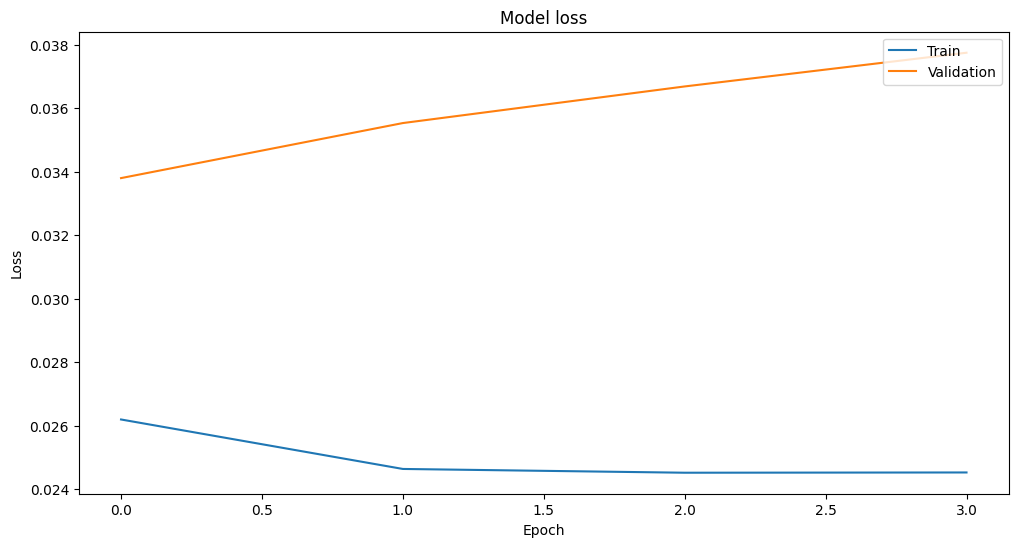

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

In [28]:

rf_model.fit(X_train_features, y_train)

y_pred = rf_model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9576335662759242
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    472549
           1       0.99      0.92      0.95    450139

    accuracy                           0.96    922688
   macro avg       0.96      0.96      0.96    922688
weighted avg       0.96      0.96      0.96    922688



In [30]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

pr_auc = auc(recall, precision)

print("Precision-Recall AUC:", pr_auc)
y_pred1 = (y_pred >= 0.5).astype(int)
print("F1 Score:", f1_score(y_test, y_pred1))

Precision-Recall AUC: 0.9763094157156811
F1 Score: 0.9548482331892225


In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, y_train)
y_pred1 = knn.predict(X_test_features)
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {accuracy1}")
print("Classification Report:")
print(classification_report(y_test, y_pred1))


Accuracy: 0.9547918689741277
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96    472549
           1       0.97      0.93      0.95    450139

    accuracy                           0.95    922688
   macro avg       0.96      0.95      0.95    922688
weighted avg       0.96      0.95      0.95    922688



In [36]:
feature_extractor.save('feature_extractor_model.keras')

In [33]:
import joblib
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(knn, 'knn.pkl')

['knn.pkl']

In [35]:
#raw features!!

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9600114014704862
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    472549
           1       1.00      0.92      0.96    450139

    accuracy                           0.96    922688
   macro avg       0.96      0.96      0.96    922688
weighted avg       0.96      0.96      0.96    922688

